# NGC7753

In this notebook we present the HI observations of the galaxy ngc7753 made with the Westerbork radio telescope. NGC7753 is a spiral galaxy located in the constellation Pegasus. It is part of the NGC 7753 group of galaxies, which also includes NGC 7752 and USNOA2-1125-19940303. The galaxy is approximately 100 million light-years away from Earth and has an apparent magnitude of around 13.5.

Authors: Angel Salazar & Quray Potosí

In [1]:
import  numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS

from reproject import reproject_interp
from astroquery.skyview import SkyView
from astroquery.vizier import Vizier
from spectral_cube import SpectralCube
import glob
from PIL import Image
import os
from IPython import display
from astropy.visualization import simple_norm


Set the directory of the files

In [2]:
directory="/home/angeldavid/Desktop/Fedora/RESEARCH-INTERSHIPS/data_cubes/NGC7753/"
cube='S2349+2904_HIcube2_clean_smooth_image_5_cube_kms.fits'
mask='S2349+2904_HIcube2_clean_smooth_image_5_mask_kms.fits'

In [3]:
def read_fits_cube(path_file):
    hdul = fits.open(path_file)
    header = hdul[0].header
    data = hdul[0].data
    return header, data

In [4]:
# import data cubes 
header_cube,data_cube=read_fits_cube(directory+cube)
header_mask,data_mask=read_fits_cube(directory+mask)

In [5]:
# apply the mask
masked_data=np.where(data_mask,data_cube,0)

## Integrated Intensity (Moment 0)

In [6]:
mom0_dat = np.nansum(masked_data,axis=0)*abs(header_cube['CDELT3'])/1000

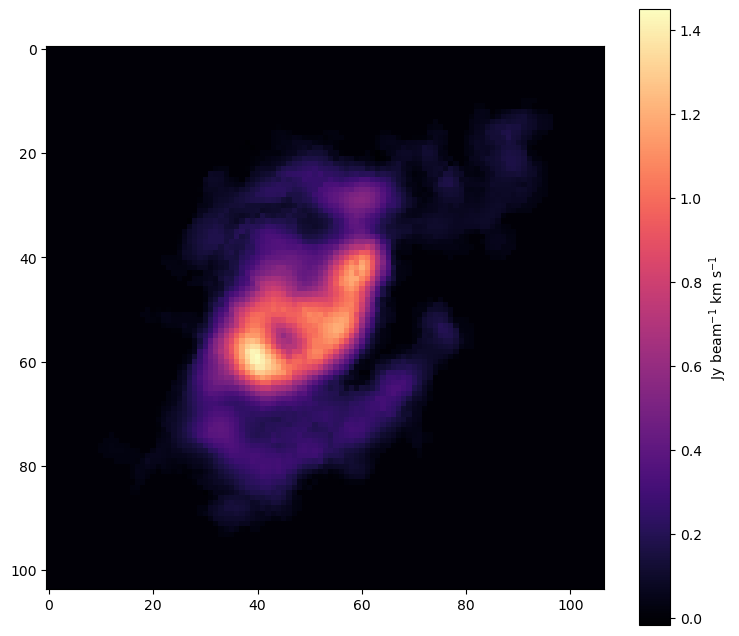

In [7]:
plt.figure(figsize=(9,8))
plt.imshow(mom0_dat,cmap='magma')
plt.colorbar(label=r'Jy beam$^{-1}$ km s$^{-1}$')
plt.show()

In [8]:
# saving the data in a afits file
def save_data(h_1,moment,data_mom):
    '''
    -h_1 is the header of the original data cube
    -moment is the name of the  map, this will be used to give the name for the fits file
    -data_mom is the data of the moment map
    '''
    wcs_new = WCS(naxis=2)
    wcs_new.wcs.cdelt = [h_1['CDELT1'], h_1['CDELT2']]
    wcs_new.wcs.ctype = [h_1['CTYPE1'], h_1['CTYPE2']]
    wcs_new.wcs.crval = [h_1['CRVAL1'], h_1['CRVAL2']]
    wcs_new.wcs.crpix = [h_1['CRPIX1'], h_1['CRPIX2']]
    header = wcs_new.to_header()        
    
# add the data and the header to an object that can be written into a file 
    hdul_new = fits.PrimaryHDU(data_mom, header=header) 
    hdul_new.writeto(directory+'{}_.fits'.format(f'ngc7753_{moment}'),overwrite=True)

In [9]:

save_data(header_cube,'mom0',mom0_dat)

In [10]:
mom0_file = "ngc7753_mom0_.fits"
header_mom0,data_mom0 = read_fits_cube(directory+mom0_file)

**Get the optical image for NGC7753, the web where we can find the galaxy image is : https://skyview.gsfc.nasa.gov/current/cgi/query.pl**  
We are going to do and overlay of the moment 0 map with on an optical image of the galaxy, for this we are going to grab an image from an online data base based on the coordinates of the HI data cube. Then we are going to grid the images to eachother to mathc the pixels and make the overlay

In [11]:
# get the central coordinate of the image
c = SkyCoord(header_mom0['CRVAL1'],header_mom0['CRVAL2'],unit='deg')
print(c.to_string('hmsdms'))

23h48m59.80617552s +29d04m15.6075168s


In [12]:
# this line grabs the image from the remote server 
#path = SkyView.get_images(position=c.to_string('hmsdms'),survey=['DSS2 Blue'],pixels=[300,300])
#hdult_opt=path[0]
#data_optical=hdul_opt[0].data
#header_optical=hdul_opt[0].header
#plt.imshow(data_optical)

**Second Option**  
We can download the optical image directly from the web source as fits file

In [13]:
optical_file='ngc7753-optical.fits'
header_optical,data_optical=read_fits_cube(directory+optical_file)


In [14]:
#test_data = fits.getdata(directory+optical_file)
#plt.imshow(test_data)

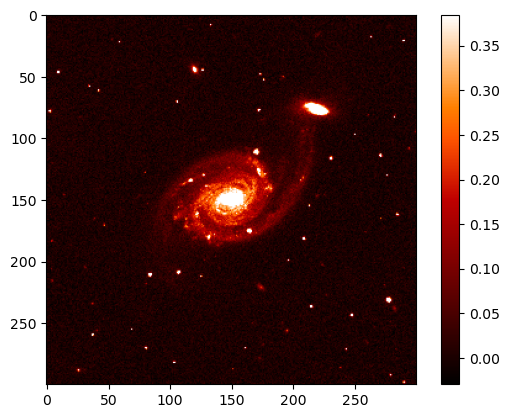

In [15]:
vmin, vmax = np.percentile(data_optical, [1, 99.5])
plt.imshow(data_optical, cmap='gist_heat', vmin=vmin, vmax=vmax)
plt.colorbar()
plt.show()


**Reproject the HI image onto the same pixel grid as the optical image**

In [16]:
def calc_rms(x):
    rms = np.sqrt(np.nanmean(x**2))
    return rms

In [17]:
hdul_mom0=fits.open(directory+mom0_file)
hi_reprojected_0,footprint = reproject_interp(hdul_mom0,header_optical)
rms_mom0 = np.sqrt(np.nanmean(hi_reprojected_0**2))

In [18]:
print(rms_mom0)
print(np.nanmax(hi_reprojected_0))

0.4064885309989523
1.447792649269104


In [19]:
#fig=plt.figure(figsize=(9,8))
#ax = fig.add_subplot(1,1,1, projection=WCS(header_mom0))
#cb=ax.imshow(data_optical,cmap='gist_heat',vmin=vmin,vmax=vmax,origin='lower')
#ax.contour(hi_reprojected_0,levels=np.arange(0,2.8,0.2)*rms_mom0,cmap='Blues_r')
#ax.contour(hi_reprojected_0, levels=15,cmap='Blues_r')
#ax.set_xlabel('RA', size=18,family='serif')
#ax.set_ylabel('Dec', size=18,family='serif')
#cbar=fig.colorbar(cb,ax=ax)
#plt.xticks(fontsize=15)
#plt.yticks(fontsize=15)
#plt.show()  

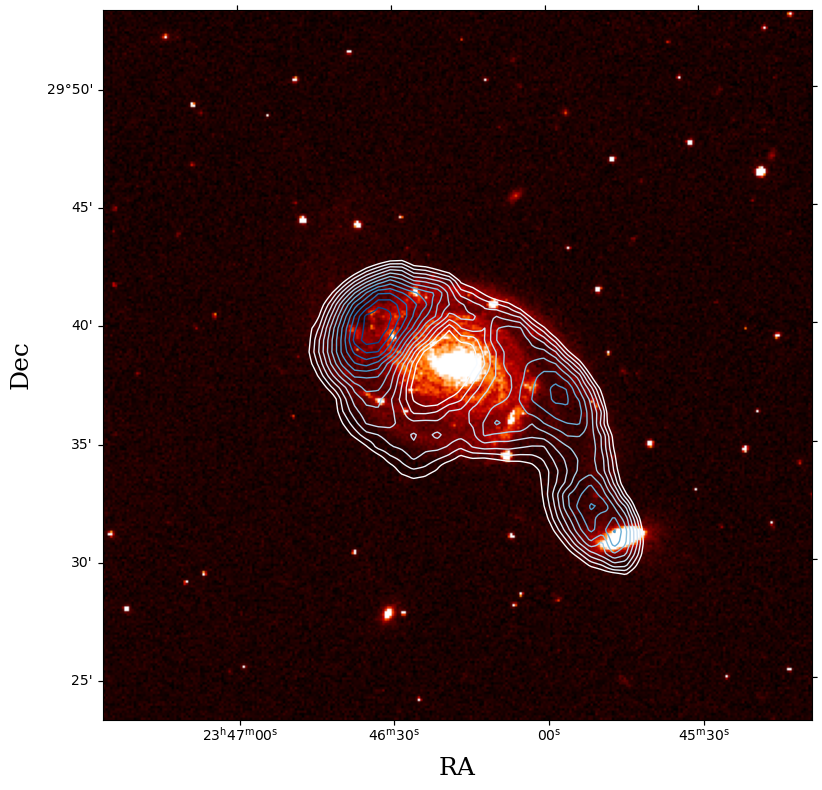

In [ ]:

fig = plt.figure(figsize=(9, 8))
ax = fig.add_subplot(1, 1, 1, projection=WCS(header_mom0))

# Background: Optical image
cb = ax.imshow(
    data_optical,
    cmap='gist_heat',  
    origin='lower',
    vmin=vmin, vmax=vmax,
)

# Contour levels from 2σ to max
levels = np.linspace(2 * rms_mom0, np.max(hi_reprojected_0), 13)

# Contour overlay in white or cyan for visibility
ax.contour(
    hi_reprojected_0,
    levels=levels,
    cmap='Blues', 
    linewidths=1,
)

ax.set_xlabel('RA', size=18, family='serif')
ax.set_ylabel('Dec', size=18, family='serif')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# 🎨 Optional colorbar (if helpful)
# cbar = fig.colorbar(cb, ax=ax)
# cbar.set_label('Optical intensity', size=14)

plt.tight_layout()
plt.show()

## Velocity Field (Moment 1 map)

In [21]:
#def compute_moment1(data,header,mom0data):
#    d_1_av=np.nansum(data[:,:,:],axis=1)
#    d_av=np.nansum(d_1_av[:,:],axis=1)
#    spectra=d_av[:-3]
#    x_axis=(np.arange(0,len(spectra))*header['CDELT3']+(header['CRVAL3']-header['CRPIX3']*header['CDELT3']))/1000
#    d_for_mom1=data.copy()
#    for i in range(len(x_axis)):
#        d_for_mom1[i,:,:] = x_axis[i]*d_for_mom1[i,:,:]
#    d_mom1=np.nansum(d_for_mom1,axis=0)*abs(header['CDELT3'])/(mom0data*1000)
#    return d_mom1

def compute_moment1(data, header, mom0data):
    n_channels = data.shape[0]
    x_axis = (np.arange(n_channels) * header['CDELT3'] +
              (header['CRVAL3'] - header['CRPIX3'] * header['CDELT3'])) / 1000  # km/s

    d_for_mom1 = data.copy()
    for i in range(n_channels):
        d_for_mom1[i, :, :] = x_axis[i] * d_for_mom1[i, :, :]

    with np.errstate(divide='ignore', invalid='ignore'):
        mom1 = np.nansum(d_for_mom1, axis=0) * abs(header['CDELT3']) / (mom0data * 1000)
        mom1[mom0data == 0] = np.nan

    return mom1



In [22]:
# moment1
computed_mom1_dat=compute_moment1(masked_data,header_cube,data_mom0)

In [23]:
print(np.nanmin(computed_mom1_dat),np.nanmax(computed_mom1_dat))
print()

4757.7983 5761.1665



Now we are going to do the reprojection with the optical image

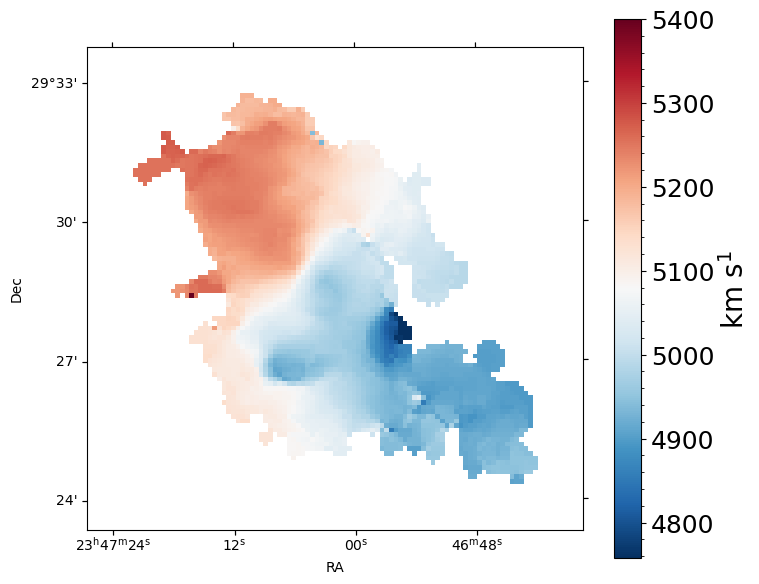

In [24]:
fig = plt.figure(figsize= (8,7))
ax=fig.add_subplot(1,1,1,projection=(WCS(header_mom0)))
cb=plt.imshow(computed_mom1_dat,cmap='RdBu_r',vmin=4757.7983,vmax=5400)
ax.set_xlabel('RA')
ax.set_ylabel('Dec')
cbar=fig.colorbar(cb)
cbar.minorticks_on()
cbar.ax.tick_params(labelsize=18)
cbar.ax.set_ylabel(r'km s$^{1}$',fontsize=20)
plt.show()

We are going to save the data for the moment 1 

In [25]:
save_data(header_cube,'mom1',computed_mom1_dat)

In [26]:
# import data for the moment 1 
mom1_file='ngc7753_mom1_.fits'
header_mom1,data_mom1=read_fits_cube(directory+mom1_file)
hdulmom1=fits.open(directory+mom1_file)

In [27]:
# compute the reprojection 
hi_mom1_rep, foot_mom1=reproject_interp(hdulmom1,header_optical)
rms_mom1=(np.sqrt(np.nanmean(hi_mom1_rep**2)))

In [28]:
print(np.nanmin(hi_mom1_rep),np.nanmax(hi_mom1_rep))
print(rms_mom1)

4757.79833984375 5668.8876953125
5085.062215553603


**Overlay of the optical image and the moment 1 map (velocity field)**

In [29]:
#fig = plt.figure(figsize=(8,7))
#ax = fig.add_subplot(1,1,1, projection=WCS(header_mom1))
#ax.imshow(data_optical, cmap='gist_gray',vmax=np.percentile(data_optical, 99.8))
#ax.contour(hi_mom1_rep, levels=10,cmap='RdBu_r')
#ax.contour(hi_mom1_rep, levels=np.arange(4800,5300,25),cmap='RdBu_r')
#ax.contour(hi_reprojected, levels=10,cmap='Blues_r')
#ax.set_xlabel('RA', size=18,family='serif')
#ax.set_ylabel('Dec', size=18,family='serif')
#plt.xticks(fontsize=15)
#plt.yticks(fontsize=15)
#plt.title('Overlay of the velocity field with the optical image')
#plt.savefig('mom1.svg')
#plt.show()

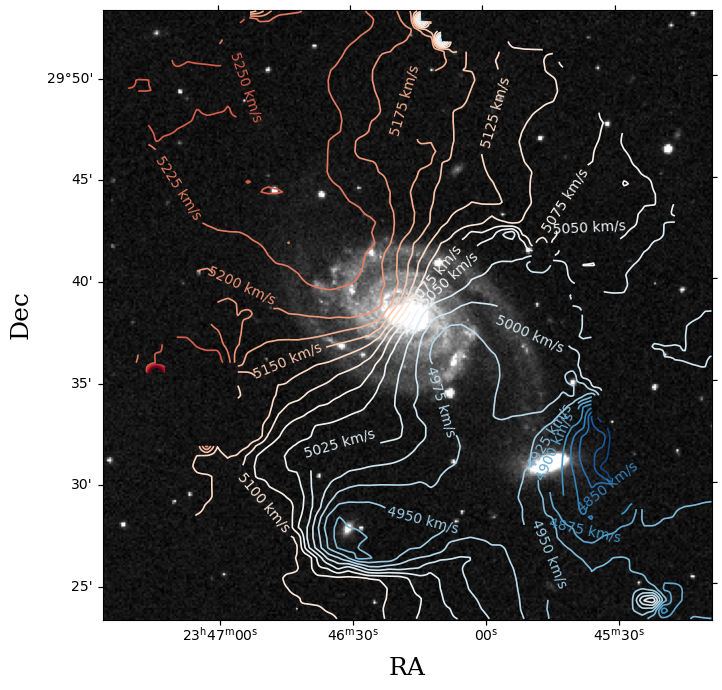

In [ ]:
fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(1, 1, 1, projection=WCS(header_mom1))

# Use log stretch for better contrast in faint structures
norm = simple_norm(data_optical, 'log', percent=99.5)
ax.imshow(data_optical, cmap='gist_gray', vmin=vmin,vmax=vmax, origin='lower')

# Velocity field (moment 1) contours: reversed RdBu, centered around systemic velocity
# Adjust levels if needed based on your specific velocity range
vel_min, vel_max = 4750, 5400  # You can automate this with np.nanmin/max if desired
levels = np.arange(vel_min, vel_max, 25)
cont = ax.contour(hi_mom1_rep, levels=levels, cmap='RdBu_r', linewidths=1.2)

# Add a colorbar for the moment 1 contours (velocity field)
# label the contour, this is optional
ax.clabel(cont, inline=True, fmt='%d km/s', fontsize=10)

ax.set_xlabel('RA', size=18, family='serif')
ax.set_ylabel('Dec', size=18, family='serif')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# save figure 
# plt.savefig('velocity_overlay.svg', dpi=300)

plt.tight_layout()
plt.show()

## Velocity Dispersion (Moment 2)

In [31]:
#def compute_moment2(data,header,moment1_dat,moment0_dat):
#    d_1_av=np.nansum(data[:,:,:],axis=1)
#    d_av=np.nansum(d_1_av[:,:],axis=1)
#    spectra=d_av[:-3]
#    x_axis=(np.arange(0,len(spectra))*header['CDELT3']+(header['CRVAL3']-header['CRPIX3']*header['CDELT3']))/1000
#    d_for_mom2=masked_data.copy()
#    for i in range(len(x_axis)):
#        d_for_mom2[i,:,:]=(x_axis[i]-moment1_dat)**2 * d_for_mom2[i,:,:]
#    d_mom2 = np.sqrt(np.nansum(d_for_mom2, axis=0)*(abs(header['CDELT3'])/(moment0_dat*1000)))
#    return d_mom2

def compute_moment2(data, header, moment1_dat, moment0_dat):
    n_channels = data.shape[0]
    # Compute velocity axis in km/s
    x_axis = (np.arange(n_channels) * header['CDELT3'] +
              (header['CRVAL3'] - header['CRPIX3'] * header['CDELT3'])) / 1000

    d_for_mom2 = np.empty_like(data)

    # Calculate squared difference from moment1
    for i in range(n_channels):
        vdiff2 = (x_axis[i] - moment1_dat)**2  # shape: (ny, nx)
        d_for_mom2[i, :, :] = vdiff2 * data[i, :, :]  # weighted squared difference

    # Now compute moment 2
    with np.errstate(divide='ignore', invalid='ignore'):
        moment2 = np.sqrt(np.nansum(d_for_mom2, axis=0) * abs(header['CDELT3']) / (moment0_dat * 1000))
        moment2[moment0_dat == 0] = np.nan  # Mask undefined areas

    return moment2


In [32]:
computed_mom2_dat=compute_moment2(masked_data,header_cube,data_mom1,data_mom0)

Save data for moment 2

In [33]:
save_data(header_cube,'mom2',computed_mom2_dat)

In [34]:
mom2_file='ngc7753_mom2_.fits'
header_mom2,data_mom2=read_fits_cube(directory+mom2_file)
hdulmom2=fits.open(directory+mom2_file)

In [35]:
hi_mom2_rep, foot_mom2=reproject_interp(hdulmom2,header_optical)
rms_mom2=(np.sqrt(np.nanmean(hi_mom1_rep**2)))

In [36]:
print(rms_mom2)
print(np.nanmin(hi_mom2_rep),np.nanmax(hi_mom2_rep))

5085.062215553603
1.4034715604793746e-05 112.88148498535156


In [37]:
#fig = plt.figure(figsize=(8,7))
#ax = fig.add_subplot(1,1,1, projection=WCS(header_mom2))
#ax.imshow(data_optical, cmap='gist_heat',vmax=np.percentile(data_optical, 99.8))
#ax.contour(hi_mom1_rep, levels=10,cmap='RdBu_r')
#ax.contour(hi_mom2_rep, levels=np.arange(0,114,10),cmap='viridis')
#ax.contour(hi_reprojected, levels=10,cmap='Blues_r')
#ax.set_xlabel('RA', size=18,family='serif')
#ax.set_ylabel('Dec', size=18,family='serif')
#plt.xticks(fontsize=15)
#plt.yticks(fontsize=15)
#plt.title('Overlay of the velocity field with the optical image')
#plt.savefig('mom1.svg')
#plt.show()

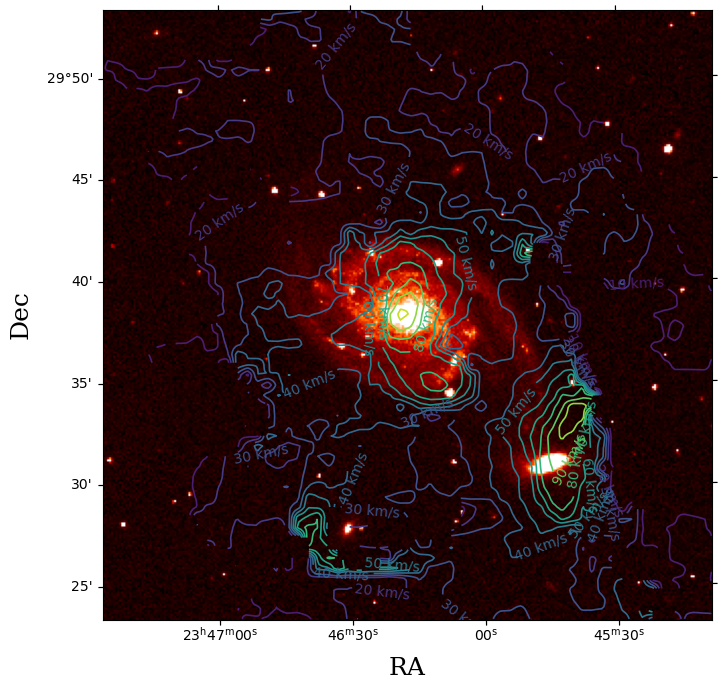

In [ ]:
fig = plt.figure(figsize=(8, 7))
ax = fig.add_subplot(1, 1, 1, projection=WCS(header_mom2))

# Improve optical background contrast
norm = simple_norm(data_optical, 'log', percent=99.5)
ax.imshow(data_optical, cmap='gist_heat', vmin=vmin,vmax=vmax, origin='lower')

# Contours for moment 2 (velocity dispersion)
disp_min, disp_max = 0, 113  # in km/s (check your units)
levels = np.arange(disp_min, disp_max + 10, 10)
cont = ax.contour(hi_mom2_rep, levels=levels, cmap='viridis', linewidths=1.2)

# Label the contours
#ax.clabel(cont, inline=True, fmt='%d km/s', fontsize=10)

# Axis formatting
ax.set_xlabel('RA', size=18, family='serif')
ax.set_ylabel('Dec', size=18, family='serif')
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# plt.savefig('moment2_overlay.svg', dpi=300)

plt.tight_layout()
plt.show()

### Two panel figure (summary)

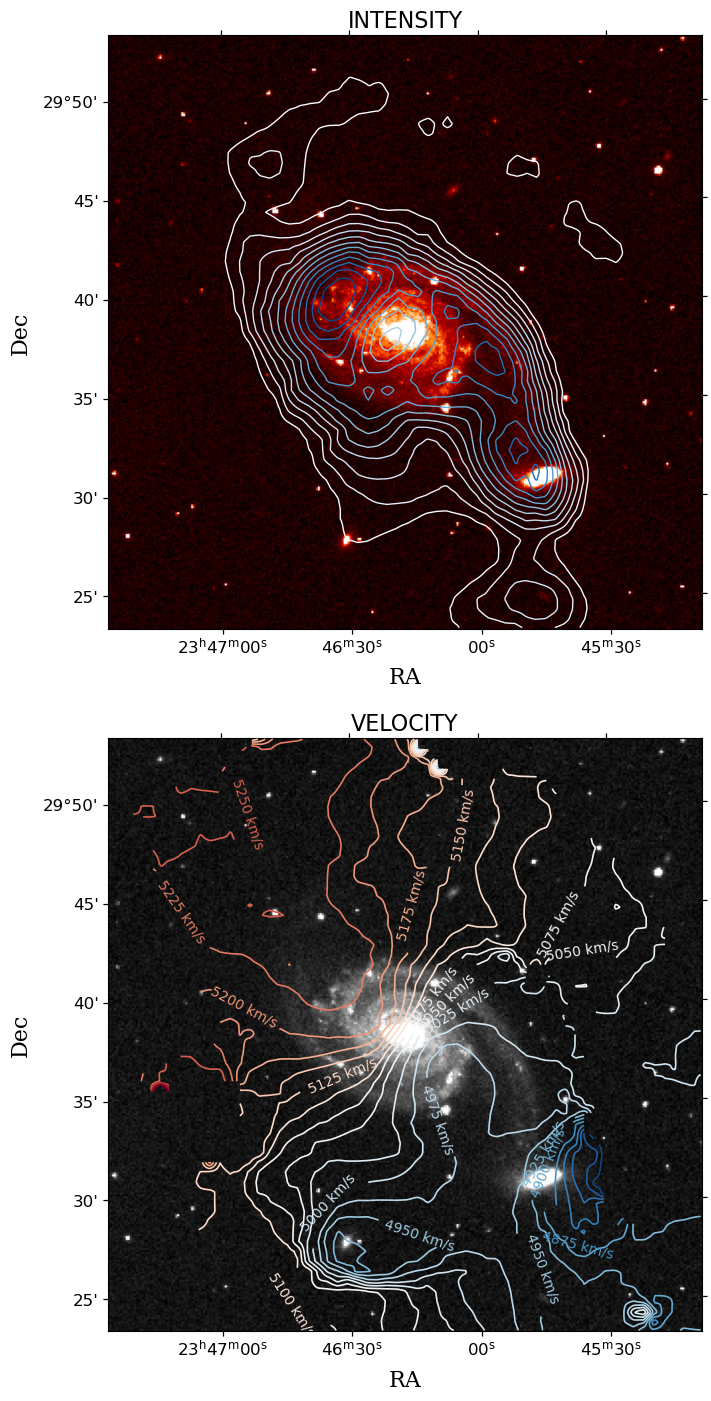

In [ ]:
# Create each axis with its own WCS projection
fig = plt.figure(figsize=(7, 14), constrained_layout=True)

#  Moment 0
ax0 = fig.add_subplot(2, 1, 1, projection=WCS(header_mom0))
cb = ax0.imshow(data_optical, cmap='gist_heat', origin='lower', vmin=vmin, vmax=vmax)
levels_mom0 = np.linspace(0.7 * rms_mom0, np.max(hi_reprojected_0), 13)
ax0.contour(hi_reprojected_0, levels=levels_mom0, cmap='Blues', linewidths=1)
ax0.set_xlabel('RA', size=16, family='serif')
ax0.set_ylabel('Dec', size=16, family='serif')
ax0.set_title('INTENSITY', fontsize=16)

#  Moment 1
ax1 = fig.add_subplot(2, 1, 2, projection=WCS(header_mom1))
norm1 = simple_norm(data_optical, 'log', percent=99.5)
ax1.imshow(data_optical, cmap='gist_gray', origin='lower', vmin=vmin, vmax=vmax)
vel_min, vel_max = 4750, 5400
levels_mom1 = np.arange(vel_min, vel_max, 25)
cont1 = ax1.contour(hi_mom1_rep, levels=levels_mom1, cmap='RdBu_r', linewidths=1.2)
ax1.clabel(cont1, inline=True, fmt='%d km/s', fontsize=10)
ax1.set_xlabel('RA', size=16, family='serif')
ax1.set_ylabel('Dec', size=16, family='serif')
ax1.set_title('VELOCITY', fontsize=16)

for ax in [ax0, ax1]:
    ax.tick_params(labelsize=12)
    ax.coords.grid(False, color='gray', ls='--', alpha=0.5)
    ax.set_aspect('equal')


#plt.savefig("moment_maps-ngc7753_vertical_2panel.jpg", dpi=300, bbox_inches='tight')
plt.show()

## BBarolo Model and Comparison

In [43]:
file_model = "/output/SoFiA_J234703.61+292835.6/SoFiA_J234703.61+292835.6mod_azim.fits"

In [44]:
header_model, data_model = read_fits_cube(directory + file_model)


***Moment 0 map with BBarolo Model***

In [45]:
mom0_dat_model = np.nansum(data_model,axis=0)*abs(header_model['CDELT3'])/1000

***Moment 1 map with BBarolo Model***

In [46]:
mom1_dat_model = compute_moment1(data_model, header_model, mom0_dat_model)

***Moment 2 map with BBarolo Model***

In [47]:
mom2_dat_model = compute_moment2(data_model, header_model,mom0_dat_model ,mom1_dat_model)

Calculate the residuals of the model 

In [48]:
residual_mom0 = mom0_dat -mom0_dat_model
residual_mom1 = computed_mom1_dat - mom1_dat_model
residual_mom2 = computed_mom2_dat - mom2_dat_model

**Maps of the data, model, and residual of each moment**

In [49]:

#fig, axs = plt.subplots(1, 3, figsize=(10, 17))
#im1 = axs[0].imshow(mom0_dat, cmap='magma')
#axs[0].set_title('Data')
#im2 = axs[1].imshow(mom0_dat_model, cmap='magma')
#axs[1].set_title('Model')
#im3 = axs[2].imshow(residual_mom0, cmap='magma')
#axs[2].set_title('Residuals')
#cbar = fig.colorbar(im3, ax=axs[2], fraction=0.046, pad=0.04)
#for ax in axs:
#    ax.invert_yaxis()

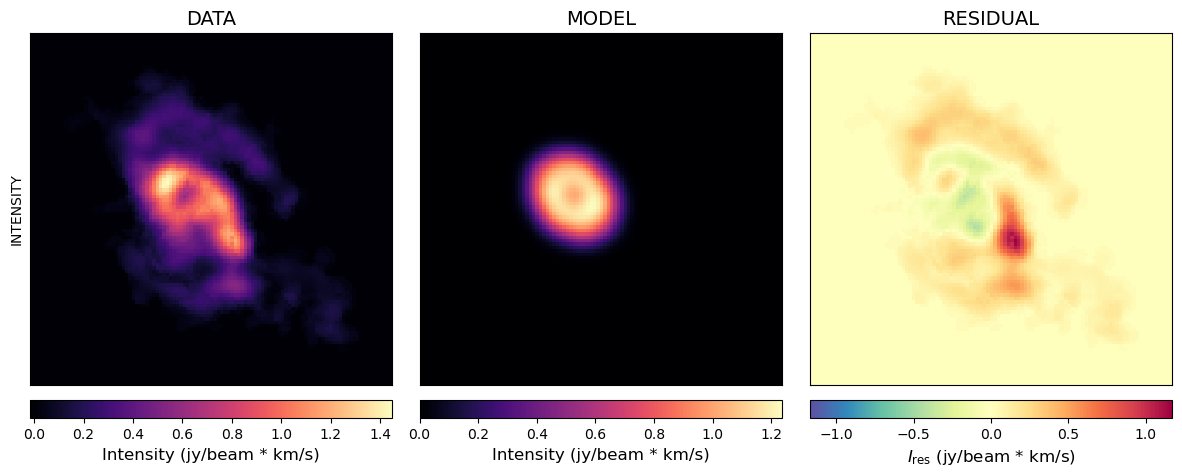

In [61]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Create figure and axes
fig, axs = plt.subplots(1, 3, figsize=(15, 5), gridspec_kw={'wspace': 0.02})  # tighter spacing

# Common image kwargs
common_kwargs = dict(origin='lower', interpolation='none')

# ---------- Panel 1: DATA ----------
im1 = axs[0].imshow(mom0_dat, cmap='magma', **common_kwargs)
axs[0].set_title('DATA', fontsize=14)
axs[0].set_ylabel('INTENSITY')
axs[0].tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)

# Add shared colorbar below first two panels
divider1 = make_axes_locatable(axs[0])
cax1 = divider1.append_axes("bottom", size="5%", pad=0.15)
cbar1 = plt.colorbar(im1, cax=cax1, orientation='horizontal')
cbar1.set_label('Intensity (jy/beam * km/s)', fontsize=12)

# ---------- Panel 2: MODEL ----------
im2 = axs[1].imshow(mom0_dat_model, cmap='magma', **common_kwargs)
axs[1].set_title('MODEL', fontsize=14)
axs[1].tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)

# Share colorbar with first panel
divider2 = make_axes_locatable(axs[1])
cax2 = divider2.append_axes("bottom", size="5%", pad=0.15)
cbar2 = plt.colorbar(im2, cax=cax2, orientation='horizontal')
cbar2.set_label('Intensity (jy/beam * km/s)', fontsize=12)

# ---------- Panel 3: RESIDUAL ----------
resid_abs_max = np.nanmax(np.abs(residual_mom0))
im3 = axs[2].imshow(residual_mom0, cmap='Spectral_r', vmin=-resid_abs_max, vmax=resid_abs_max, **common_kwargs)
axs[2].set_title('RESIDUAL', fontsize=14)
axs[2].tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)

# Separate colorbar for residuals
divider3 = make_axes_locatable(axs[2])
cax3 = divider3.append_axes("bottom", size="5%", pad=0.15)
cbar3 = plt.colorbar(im3, cax=cax3, orientation='horizontal')   
cbar3.set_label(r'$I_{\mathrm{res}}$ (jy/beam * km/s)', fontsize=12)

# Equal aspect ratio for all panels
for ax in axs:
    ax.set_aspect('equal')

# Optional export
plt.savefig("moment0_panels_fixed.jpg", dpi=300, bbox_inches='tight')
# plt.savefig("moment0_model.eps",format="eps", dpi=300, bbox_inches='tight')
plt.show()


In [53]:
print(np.nanmin(mom1_dat_model),np.nanmax(mom1_dat_model))

4956.333 5236.6455


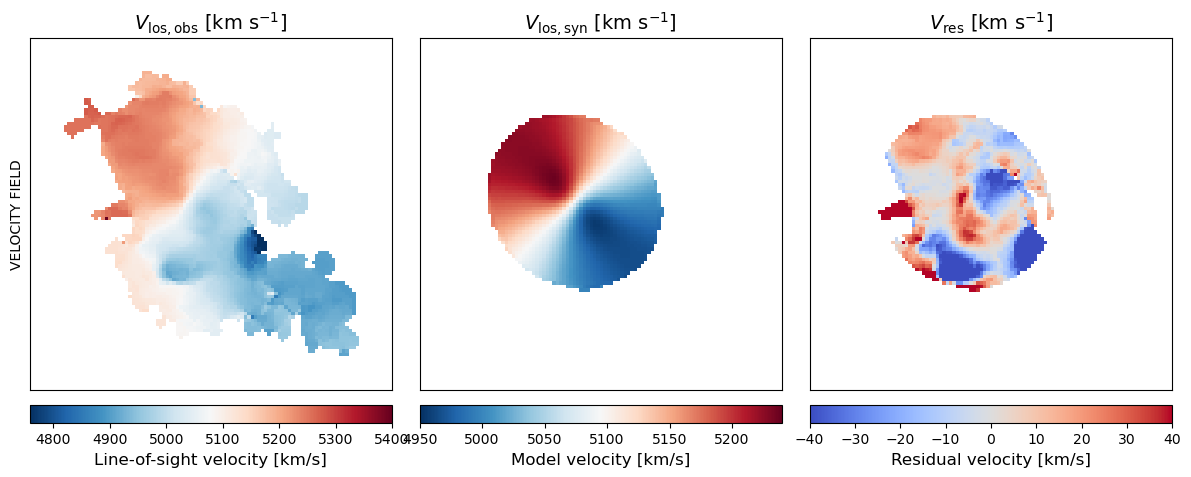

In [54]:
# Create figure and axes
fig, axs = plt.subplots(1, 3, figsize=(15, 5), gridspec_kw={'wspace': 0.02})

# Shared image display settings
common_kwargs = dict(origin='lower', interpolation='none')

# ---------- Panel 1: Observed velocity ----------
im1 = axs[0].imshow(computed_mom1_dat, cmap='RdBu_r', vmin=4757.7983, vmax=5400, **common_kwargs)
axs[0].set_title(r'$V_{\mathrm{los,obs}}$ [km s$^{-1}$]', fontsize=14)
axs[0].set_ylabel('VELOCITY FIELD')
axs[0].tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)

divider1 = make_axes_locatable(axs[0])
cax1 = divider1.append_axes("bottom", size="5%", pad=0.15)
cbar1 = plt.colorbar(im1, cax=cax1, orientation='horizontal')
cbar1.set_label('Line-of-sight velocity [km/s]', fontsize=12)

# ---------- Panel 2: Model velocity ----------
im2 = axs[1].imshow(mom1_dat_model, cmap='RdBu_r', vmin=4950, vmax=5240, **common_kwargs)
axs[1].set_title(r'$V_{\mathrm{los,syn}}$ [km s$^{-1}$]', fontsize=14)
axs[1].tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)

divider2 = make_axes_locatable(axs[1])
cax2 = divider2.append_axes("bottom", size="5%", pad=0.15)
cbar2 = plt.colorbar(im2, cax=cax2, orientation='horizontal')
cbar2.set_label('Model velocity [km/s]', fontsize=12)

# ---------- Panel 3: Residual velocity ----------
resid_vlim = 40  # km/s
im3 = axs[2].imshow(residual_mom1, cmap='coolwarm', vmin=-resid_vlim, vmax=resid_vlim, **common_kwargs)
axs[2].set_title(r'$V_{\mathrm{res}}$ [km s$^{-1}$]', fontsize=14)
axs[2].tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)

divider3 = make_axes_locatable(axs[2])
cax3 = divider3.append_axes("bottom", size="5%", pad=0.15)
cbar3 = plt.colorbar(im3, cax=cax3, orientation='horizontal')
cbar3.set_label(r'Residual velocity [km/s]', fontsize=12)

# Format all panels
for ax in axs:
    ax.set_aspect('equal')

# Optional: Export as publication-quality PDF
# plt.savefig("moment1_threepanel_velocity.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [80]:
#fig, axs = plt.subplots(1, 3, figsize=(10, 15))
#im1 = axs[0].imshow(computed_mom2_dat, cmap='viridis')
#axs[0].set_title('Data')
#im2 = axs[1].imshow(mom2_dat_model, cmap='viridis')
#axs[1].set_title('Model')
#im3 = axs[2].imshow(residual_mom2, cmap='viridis',vmin=-100,vmax=100)
#axs[2].set_title('Residuals')
#cbar = fig.colorbar(im3, ax=axs[2], fraction=0.046, pad=0.04)
#for ax in axs:
#    ax.invert_yaxis()

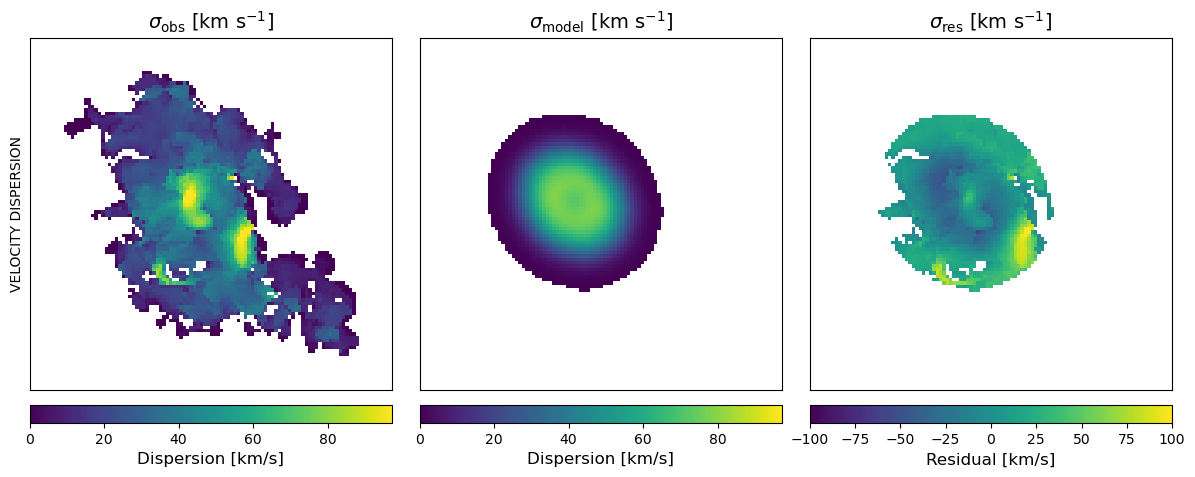

In [55]:

# Create figure and axes with tight spacing
fig, axs = plt.subplots(1, 3, figsize=(15, 5), gridspec_kw={'wspace': 0.02})

# Shared display settings
common_kwargs = dict(origin='lower', interpolation='none')

# ---------- Panel 1: Observed dispersion ----------
vmin_m2 = 0
vmax_m2 = np.nanpercentile(computed_mom2_dat, 99.5)
im1 = axs[0].imshow(computed_mom2_dat, cmap='viridis', vmin=vmin_m2, vmax=vmax_m2, **common_kwargs)
axs[0].set_title(r'$\sigma_{\mathrm{obs}}$ [km s$^{-1}$]', fontsize=14)
axs[0].set_ylabel('VELOCITY DISPERSION')
axs[0].tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)

divider1 = make_axes_locatable(axs[0])
cax1 = divider1.append_axes("bottom", size="5%", pad=0.15)
cbar1 = plt.colorbar(im1, cax=cax1, orientation='horizontal')
cbar1.set_label('Dispersion [km/s]', fontsize=12)

# ---------- Panel 2: Model dispersion ----------
im2 = axs[1].imshow(mom2_dat_model, cmap='viridis', vmin=vmin_m2, vmax=vmax_m2, **common_kwargs)
axs[1].set_title(r'$\sigma_{\mathrm{model}}$ [km s$^{-1}$]', fontsize=14)
axs[1].tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)

divider2 = make_axes_locatable(axs[1])
cax2 = divider2.append_axes("bottom", size="5%", pad=0.15)
cbar2 = plt.colorbar(im2, cax=cax2, orientation='horizontal')
cbar2.set_label('Dispersion [km/s]', fontsize=12)

# ---------- Panel 3: Residual dispersion ----------
resid_lim = 100  # km/s
im3 = axs[2].imshow(residual_mom2, cmap='viridis', vmin=-resid_lim, vmax=resid_lim, **common_kwargs)
axs[2].set_title(r'$\sigma_{\mathrm{res}}$ [km s$^{-1}$]', fontsize=14)
axs[2].tick_params(labelbottom=False, labelleft=False, bottom=False, left=False)

divider3 = make_axes_locatable(axs[2])
cax3 = divider3.append_axes("bottom", size="5%", pad=0.15)
cbar3 = plt.colorbar(im3, cax=cax3, orientation='horizontal')
cbar3.set_label('Residual [km/s]', fontsize=12)

# Consistent appearance
for ax in axs:
    ax.set_aspect('equal')

# Optional: Export figure
# plt.savefig("moment2_threepanel_dispersion.pdf", dpi=300, bbox_inches='tight')
plt.show()


## Prepare the data to isolate the companion galaxy

In [47]:
data_new_galaxy = data_cube - data_model

In [48]:
mom0_dat_new = np.nansum(data_new_galaxy,axis=0)*abs(header_model['CDELT3'])/1000

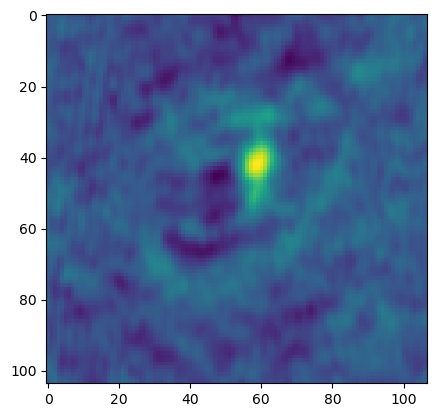

In [49]:
# quick inspection 
plt.imshow(mom0_dat_new)

In [51]:
directory_new = "/home/angeldavid/Desktop/Fedora/RESEARCH-INTERSHIPS/data_cubes/NGC7752/"
hdul_new = fits.PrimaryHDU(data_new_galaxy,header=header_cube)
hdul_new.writeto(directory_new + 'ngc7752_cube.fits', overwrite=True)